# Implementing Proximal Policy Optimization 


In this notebook you will be implementing Proximal Policy Optimization algorithm, 
scaled up version of which was used to train [OpenAI Five](https://openai.com/blog/openai-five/) 
to [win](https://openai.com/blog/how-to-train-your-openai-five/) against the
world champions in Dota 2.
You will be solving a continuous control environment on which it may be easier and faster 
to train an agent, however note that PPO here may not be the best algorithm as, for example,
Deep Deterministic Policy Gradient and Soft Actor Critic may be more suited 
for continuous control environments. To run the environment you will need to install 
[pybullet-gym](https://github.com/benelot/pybullet-gym) which unlike MuJoCo 
does not require you to have a license.

To install the library:

In [1]:
# !git clone https://github.com/benelot/pybullet-gym lib/pybullet-gym
# !pip install -e lib/pybullet-gym

#### Attention
####I installed pybullet=2.5.9 after previous Cell

The overall structure of the code is similar to the one in the A2C optional homework, but don't worry if you haven't done it, it should be relatively easy to figure it out. 
First, we will create an instance of the environment. 
We will normalize the observations and rewards, but before that you will need a wrapper that will 
write summaries, mainly, the total reward during an episode. You can either use one for `TensorFlow` 
implemented in `atari_wrappers.py` file from the optional A2C homework, or implement your own. 

In [2]:
# pylint: skip-file
from multiprocessing import Process, Pipe

from gym import Env, Wrapper, Space
import numpy as np


class SpaceBatch(Space):
    def __init__(self, spaces):
        first_type = type(spaces[0])
        first_shape = spaces[0].shape
        first_dtype = spaces[0].dtype
        for space in spaces:
            if not isinstance(space, first_type):
                raise TypeError("spaces have different types: {}, {}"
                                .format(first_type, type(space)))
            if first_shape != space.shape:
                raise ValueError("spaces have different shapes: {}, {}"
                                 .format(first_shape, space.shape))
            if first_dtype != space.dtype:
                raise ValueError("spaces have different data types: {}, {}"
                                 .format(first_dtype, space.dtype))

        self.spaces = spaces
        super(SpaceBatch, self).__init__(shape=self.spaces[0].shape,
                                         dtype=self.spaces[0].dtype)

    def sample(self):
        return np.stack([space.sample() for space in self.spaces])

    def __getattr__(self, attr):
        return getattr(self.spaces[0], attr)


class EnvBatch(Env):
    def __init__(self, make_env, nenvs=None):
        make_env_functions = self._get_make_env_functions(make_env, nenvs)
        self._envs = [make_env() for make_env in make_env_functions]
        self._nenvs = len(self.envs)
        # self.observation_space = SpaceBatch([env.observation_space
        #                                      for env in self._envs])
        self.action_space = SpaceBatch([env.action_space
                                        for env in self._envs])

    def _get_make_env_functions(self, make_env, nenvs):
        if nenvs is None and not isinstance(make_env, list):
            raise ValueError("When nenvs is None make_env"
                             " must be a list of callables")
        if nenvs is not None and not callable(make_env):
            raise ValueError(
                "When nenvs is not None make_env must be callable")

        if nenvs is not None:
            make_env = [make_env for _ in range(nenvs)]
        return make_env

    @property
    def nenvs(self):
        return self._nenvs

    @property
    def envs(self):
        return self._envs

    def _check_actions(self, actions):
        if not len(actions) == self.nenvs:
            raise ValueError(
                "number of actions is not equal to number of envs: "
                "len(actions) = {}, nenvs = {}"
                .format(len(actions), self.nenvs))

    def step(self, actions):
        self._check_actions(actions)
        obs, rews, resets, infos = [], [], [], []
        for env, action in zip(self._envs, actions):
            ob, rew, done, info = env.step(action)
            if done:
                ob = env.reset()
            obs.append(ob)
            rews.append(rew)
            resets.append(done)
            infos.append(info)
        return np.stack(obs), np.stack(rews), np.stack(resets), infos

    def reset(self):
        return np.stack([env.reset() for env in self.envs])


class SingleEnvBatch(Wrapper, EnvBatch):
    def __init__(self, env):
        super(SingleEnvBatch, self).__init__(env)
        self.observation_space = SpaceBatch([self.env.observation_space])
        self.action_space = SpaceBatch([self.env.action_space])

    @property
    def nenvs(self):
        return 1

    @property
    def envs(self):
        return [self.env]

    def step(self, actions):
        self._check_actions(actions)
        ob, rew, done, info = self.env.step(actions[0])
        if done:
            ob = self.env.reset()
        return (
            ob[None],
            np.expand_dims(rew, 0),
            np.expand_dims(done, 0),
            [info],
        )

    def reset(self):
        return self.env.reset()[None]


def worker(parent_connection, worker_connection, make_env_function,
           send_spaces=True):
    # Adapted from SubprocVecEnv github.com/openai/baselines
    parent_connection.close()
    env = make_env_function()
    if send_spaces:
        worker_connection.send((env.observation_space, env.action_space))
    while True:
        cmd, action = worker_connection.recv()
        if cmd == "step":
            ob, rew, done, info = env.step(action)
            if done:
                ob = env.reset()
            worker_connection.send((ob, rew, done, info))
        elif cmd == "reset":
            ob = env.reset()
            worker_connection.send(ob)
        elif cmd == "close":
            env.close()
            worker_connection.close()
            break
        else:
            raise NotImplementedError("Unknown command %s" % cmd)


class ParallelEnvBatch(EnvBatch):
    """
    An abstract batch of environments.
    """

    def __init__(self, make_env, nenvs=None):
        make_env_functions = self._get_make_env_functions(make_env, nenvs)
        self._nenvs = len(make_env_functions)
        self._parent_connections, self._worker_connections = zip(*[
            Pipe() for _ in range(self._nenvs)
        ])
        self._processes = [
            Process(
                target=worker,
                args=(parent_connection, worker_connection, make_env),
                daemon=True
            )
            for i, (parent_connection, worker_connection, make_env)
            in enumerate(zip(self._parent_connections,
                             self._worker_connections,
                             make_env_functions))
        ]
        for p in self._processes:
            p.start()
        self._closed = False

        for conn in self._worker_connections:
            conn.close()

        observation_spaces, action_spaces = [], []
        for conn in self._parent_connections:
            ob_space, ac_space = conn.recv()
            observation_spaces.append(ob_space)
            action_spaces.append(ac_space)
        self.observation_space = SpaceBatch(observation_spaces)
        self.action_space = SpaceBatch(action_spaces)

    @property
    def nenvs(self):
        return self._nenvs

    def step(self, actions):
        self._check_actions(actions)
        for conn, a in zip(self._parent_connections, actions):
            conn.send(("step", a))
        results = [conn.recv() for conn in self._parent_connections]
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for conn in self._parent_connections:
            conn.send(("reset", None))
        return np.stack([conn.recv() for conn in self._parent_connections])

    def close(self):
        if self._closed:
            return
        for conn in self._parent_connections:
            conn.send(("close", None))
        for p in self._processes:
            p.join()
        self._closed = True

    def render(self):
        raise ValueError("render not defined for %s" % self)
        
        
""" Environment wrappers. """
from collections import defaultdict, deque

import cv2
import gym
import gym.spaces as spaces
from gym.envs import atari
import numpy as np
from mujoco_wrappers import Normalize

cv2.ocl.setUseOpenCL(False)


class EpisodicLife(gym.Wrapper):
    """ Sets done flag to true when agent dies. """

    def __init__(self, env):
        super(EpisodicLife, self).__init__(env)
        self.lives = 0
        self.real_done = True

    def step(self, action):
        obs, rew, done, info = self.env.step(action)
        self.real_done = done
        info["real_done"] = done
        lives = self.env.unwrapped.ale.lives()
        if 0 < lives < self.lives:
            done = True
        self.lives = lives
        return obs, rew, done, info

    def reset(self, **kwargs):
        if self.real_done:
            obs = self.env.reset(**kwargs)
        else:
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs



def nature_dqn_env(env_id, nenvs=None, seed=None,
                   summaries='TensorFlow', clip_reward=True):
    """ Wraps env as in Nature DQN paper. """
    if nenvs is not None:
        if seed is None:
            seed = list(range(nenvs))
        if isinstance(seed, int):
            seed = [seed] * nenvs
        if len(seed) != nenvs:
            raise ValueError(f"seed has length {len(seed)} but must have "
                             f"length equal to nenvs which is {nenvs}")

        env = ParallelEnvBatch([
            lambda i=i, env_seed=env_seed: nature_dqn_env(
                env_id, seed=env_seed, summaries=False, clip_reward=False)
            for i, env_seed in enumerate(seed)
        ])
        return env

    env = gym.make(env_id)
    env.seed(seed)
    env = Normalize(env)
#     env = EpisodicLife(env)
    return env
       

In [3]:
import gym 
import pybulletgym

env = nature_dqn_env("HalfCheetahMuJoCoEnv-v0", nenvs=8, summaries='Numpy')
print("observation space: ", env.observation_space,
      "\nobservations:", env.reset().shape)
print("action space: ", env.action_space, 
      "\naction_sample: ", env.action_space.sample().shape)

current_dir=/home/arsen/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet


/home/arsen/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


WalkerBase::__init__
current_dir=/home/arsen/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet
current_dir=/home/arsen/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet


/home/arsen/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/arsen/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


WalkerBase::__init__
WalkerBase::__init__
current_dir=/home/arsen/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet
current_dir=/home/arsen/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet
current_dir=/home/arsen/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet


/home/arsen/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/arsen/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


current_dir=/home/arsen/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet


/home/arsen/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


WalkerBase::__init__
WalkerBase::__init__
current_dir=/home/arsen/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet


/home/arsen/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/arsen/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


WalkerBase::__init__
WalkerBase::__init__
WalkerBase::__init__
options= 
options= 
options= 
options= 
options= 
options= 
options= 
options= 
observation space:  <__main__.SpaceBatch object at 0x7f427fd58dd0> 
observations: (8, 17)
action space:  <__main__.SpaceBatch object at 0x7f427fd6dcd0> 
action_sample:  (8, 6)


Process Process-1:
Process Process-2:
Process Process-7:
Process Process-3:
Traceback (most recent call last):
  File "/home/arsen/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Process-6:
Process Process-5:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/arsen/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/arsen/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Process-8:
Traceback (most recent call last):
  File "/home/arsen/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/arsen/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<ipython-inp

The normalization wrapper will subtract running mean from observations and rewards and divide 
the resulting quantities by the  running variances.

Next, you will need to define a model for training. We suggest that you use two separate networks: one for policy
and another for value function. Each network should be a 3-layer MLP with 64 hidden units, $\mathrm{tanh}$ 
activation function, kernel matrices initialized with orthogonal initializer with parameter $\sqrt{2}$
and biases initialized with zeros. 

Our policy distribution is going to be multivariate normal with diagonal covariance. 
The network from above will predict the mean, and the covariance should be represented by a single 
(learned) vector of size 6 (corresponding to the dimensionality of the action space from above). 
You should initialize this vector to zero and take the exponent of it to always
have a non-negative quantity. 

Overall the model should return three things: predicted mean of the distribution, variance vector, 
value function. 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def ortho_weights(shape, scale=1.):
    """ PyTorch port of ortho_init from baselines.a2c.utils """
    shape = tuple(shape)

    if len(shape) == 2:
        flat_shape = shape[1], shape[0]
    elif len(shape) == 4:
        flat_shape = (np.prod(shape[1:]), shape[0])
    else:
        raise NotImplementedError

    a = np.random.normal(0., 1., flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.transpose().copy().reshape(shape)

    if len(shape) == 2:
        return torch.from_numpy((scale * q).astype(np.float32))
    if len(shape) == 4:
        return torch.from_numpy((scale * q[:, :shape[1], :shape[2]]).astype(np.float32))


def atari_initializer(module):
    """ Parameter initializer for Atari models
    Initializes Linear, Conv2d, and LSTM weights.
    """
    classname = module.__class__.__name__
    if classname == 'Linear':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()
                

class PolicyNetwork(nn.Module):
    
    def __init__(self, shape_in, action_shape, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.dense1 = nn.Linear(shape_in, hidden_size)
        self.dense2 = nn.Linear(hidden_size, action_shape)
        self.dense3 = nn.Linear(hidden_size, action_shape)
        self.apply(atari_initializer)
    def forward(self, inputs):
        hid = torch.tanh(self.dense1(inputs))
        mu = torch.tanh(self.dense2(hid))
        sigma = F.softplus(self.dense3(hid)) + 1e-8
        return mu, sigma

class ValueNetwork(nn.Module):
    
    def __init__(self, shape_in, hidden_size=64):
        super(ValueNetwork, self).__init__()
        self.dense1 = nn.Linear(shape_in, hidden_size)
        self.dense2 = nn.Linear(hidden_size, 1)
        self.apply(atari_initializer)
    def forward(self, inputs):
        hid = torch.tanh(self.dense1(inputs))
        return self.dense2(hid)
    
    
class Network(nn.Module):
    def __init__(self, shape_in, action_shape, hidden_size=64):
        super(Network, self).__init__()
        self.policy = PolicyNetwork(shape_in, action_shape, hidden_size)
        self.value = ValueNetwork(shape_in, hidden_size)
    def forward(self, inputs):
        return self.policy(inputs), self.value(inputs)

This model will be wrapped by a `Policy`. The policy can work in two modes, but in either case 
it is going to return dictionary with string-type keys. The first mode is when the policy is 
used to sample actions for a trajectory which will later be used for training. In this case 
the flag `training` passed to `act` method is `False` and the method should return 
a `dict` with the following keys: 

* `"actions"`: actions to pass to the environment
* `"log_probs"`: log-probabilities of sampled actions
* `"values"`: value function $V^\pi(s)$ predictions.

We don't need to use the values under these keys for training, so all of them should be of type `np.ndarray`.

When `training` is `True`, the model is training on a given batch of observations. In this
case it should return a `dict` with the following keys

* `"distribution"`: an instance of multivariate normal distribution (`torch.distributions.MultivariateNormal` or `tf.distributions.MultivariateNormalDiag`)
* `"values"`: value function $V^\pi(s)$ prediction.

The distinction about the modes comes into play depending on where the policy is used: if it is called from `EnvRunner`, 
the `training` flag is `False`, if it is called from `PPO`, the `training` flag is `True`. These classed 
will be described below. 

In [5]:
class Policy:
    def __init__(self, model):
        self.model = model
    
    def act(self, inputs, training=False):
        inputs = torch.tensor(inputs, dtype=torch.float32)
        (mus, sigmas), values = self.model(inputs)
        dist = torch.distributions.MultivariateNormal(mus, torch.diag_embed(sigmas, 0))
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        if training:
            return {'distribution': dist,
                    'values': values[:, 0]}
        else:
            return {'actions': actions.detach().numpy(),
                    'log_probs': log_probs.detach().numpy(),
                    'values': values[:,0].detach().numpy()}

We will use `EnvRunner` to perform interactions with an environment with a policy for a fixed number of timesteps. Calling `.get_next()` on a runner will return a trajectory &mdash; dictionary 
containing keys

* `"observations"`
* `"rewards"` 
* `"resets"`
* `"actions"`
* all other keys that you defined in `Policy`,

under each of these keys there is a `np.ndarray` of specified length $T$ &mdash; the size of partial trajectory. 

Additionally, before returning a trajectory this runner can apply a list of transformations. 
Each transformation is simply a callable that should modify passed trajectory in-place.

In [6]:
class AsArray:
    """ 
       Converts lists of interactions to ndarray.
    """
    def __call__(self, trajectory):
      # Modify trajectory inplace. 
      for k, v in filter(lambda kv: kv[0] != "state",
                         trajectory.items()):
        trajectory[k] = np.asarray(v)

In [7]:
env.reset().shape

(8, 17)

In [8]:
class EnvRunner:
    """ Reinforcement learning runner in an environment with given policy """

    def __init__(self, env, policy, nsteps, transforms=None, step_var=None):
        self.env = env
        self.policy = policy
        self.nsteps = nsteps
        self.transforms = transforms or []
        self.step_var = step_var if step_var is not None else 0
        self.state = {"latest_observation": self.env.reset()}

    @property
    def nenvs(self):
        """ Returns number of batched envs or `None` if env is not batched """
        return getattr(self.env.unwrapped, "nenvs", None)

    def reset(self):
        """ Resets env and runner states. """
        self.state["latest_observation"] = self.env.reset()
        self.policy.reset()

    def get_next(self):
        """ Runs the agent in the environment.  """
        trajectory = defaultdict(list, {"actions": []})
        observations = []
        rewards = []
        resets = []
        self.state["env_steps"] = self.nsteps

        for i in range(self.nsteps):
            observations.append(self.state["latest_observation"])
            act = self.policy.act(self.state["latest_observation"])
            if "actions" not in act:
                raise ValueError("result of policy.act must contain 'actions' "
                                 f"but has keys {list(act.keys())}")

            for key, val in act.items():
                trajectory[key].append(val)

            obs, rew, done, _ = self.env.step(trajectory["actions"][-1])
            self.state["latest_observation"] = obs
            rewards.append(rew)
            resets.append(done)
            self.step_var += self.nenvs or 1

            # Only reset if the env is not batched. Batched envs should
            # auto-reset.
            if not self.nenvs and np.all(done):
                self.state["env_steps"] = i + 1
                self.state["latest_observation"] = self.env.reset()

        trajectory.update(
            observations=observations,
            rewards=rewards,
            resets=resets)
        trajectory["state"] = self.state

        for transform in self.transforms:
            transform(trajectory)
        return trajectory

In [9]:
import numpy as np
# from runners import EnvRunner

class DummyPolicy:
    def act(self, inputs, training=False):
        assert not training
        return {"actions": np.array([np.random.randn(6)]*8), "values": [np.nan]*8}

runner = EnvRunner(env, DummyPolicy(), 30,
                   transforms=[AsArray()])
trajectory = runner.get_next()

{k: v.shape for k, v in trajectory.items() if k != "state"}

{'actions': (30, 8, 6),
 'values': (30, 8),
 'observations': (30, 8, 17),
 'rewards': (30, 8),
 'resets': (30, 8)}

You will need to implement the following two transformations. 

The first is `GAE` that implements [Generalized Advantage Estimator](https://arxiv.org/abs/1506.02438).
In it you should add two keys to the trajectory: `"advantages"` and `"value_targets"`. In GAE the advantages
$A_t^{\mathrm{GAE}(\gamma,\lambda)}$ are essentially defined as the exponential 
moving average with parameter $\lambda$ of the regular advantages 
$\hat{A}^{(T)}(s_t) = \sum_{l=0}^{T-1-t} \gamma^l r_{t+l} + \gamma^{T} V^\pi(s_{T}) - V^\pi(s_t)$. 
The exact formula for the computation is the following

$$
A_{t}^{\mathrm{GAE}(\gamma,\lambda)} = \sum_{l=0}^{T-1-t} (\gamma\lambda)^l\delta_{t + l}^V, \, t \in [0, T)
$$
where $\delta_{t+l}^V = r_{t+l} + \gamma V^\pi(s_{t+l+1}) - V^\pi(s_{t+l})$. You can look at the 
derivation (formulas 11-16) in the paper. Don't forget to reset the summation on terminal
states as determined by the flags `trajectory["resets"]`. You can use `trajectory["values"]`
to get values of all observations except the most recent which is stored under 
 `trajectory["state"]["latest_observation"]`. For this observation you will need to call the policy 
 to get the value prediction.

Once you computed the advantages, you can get the targets for training the value function by adding 
back values:
$$
\hat{V}(s_{t+l}) = A_{t+l}^{\mathrm{GAE}(\gamma,\lambda)} + V(s_{t + l}),
$$
where $\hat{V}$ is a tensor of value targets that are used to train the value function. 

In [10]:
class GAE:
    """ Generalized Advantage Estimator. """
    def __init__(self, policy, gamma=0.99, lambda_=0.95):
        self.policy = policy
        self.gamma = gamma
        self.lambda_ = lambda_
    
    def __call__(self, trajectory):
        value_target = policy.act(trajectory['state']['latest_observation'])['values']
        env_steps = trajectory['state']['env_steps']
        rewards = trajectory['rewards']
        is_not_done = 1 - trajectory['resets']
        trajectory['advantages'] = []
        trajectory['value_targets'] = []
        gae = 0
        for step in reversed(range(env_steps)):
            if step==env_steps - 1:
                delta = rewards[step] + self.gamma*value_target*is_not_done[step] - trajectory['values'][step]
            else:
                delta = rewards[step] + self.gamma*trajectory['values'][step + 1]*is_not_done[step] -\
                        trajectory['values'][step]
            
            gae = delta + self.gamma*self.lambda_*is_not_done[step]*gae
            trajectory['advantages'].insert(0, gae)
            trajectory['value_targets'].insert(0, gae + trajectory['values'][step])
        keys = ['advantages', 'value_targets', 'values', 'log_probs', 'actions']
        for key in keys:
            trajectory[key] = torch.tensor(trajectory[key], dtype=torch.float32)

The main advantage of PPO over simpler policy based methods like A2C is that it is possible
to train on the same trajectory for multiple gradient steps. The following class wraps 
an `EnvRunner`. It should call the runner to get a trajectory, then return minibatches 
from it for a number of epochs, shuffling the data before each epoch.

In [11]:
class TrajectorySampler:
    """ Samples minibatches from trajectory for a number of epochs. """
    def __init__(self, runner, num_epochs, num_minibatches, transforms=None):
        self.runner = runner
        self.num_epochs = num_epochs
        self.num_minibatches = num_minibatches
        self.transforms = transforms or []
        self.minibatch_count = 0
        self.epoch_count = 0
        self.trajectory = None
    def shuffle_trajectory(self):
        """ Shuffles all elements in trajectory.
            Should be called at the beginning of each epoch.
        """
        pass
    
    def get_next(self):
        """ Returns next minibatch.  """
        self.trajectory = self.runner.get_next()
        return self.trajectory


A common trick to use with GAE is to normalize advantages, the following transformation does that. 

In [12]:
class NormalizeAdvantages:
    """ Normalizes advantages to have zero mean and variance 1. """
    def __call__(self, trajectory):
        adv = trajectory["advantages"]
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)
        trajectory["advantages"] = adv

Finally, we can create our PPO runner. 

In [13]:
def make_ppo_runner(env, policy, num_runner_steps=20,
                    gamma=0.99, lambda_=0.95, 
                    num_epochs=10, num_minibatches=32):
    """ Creates runner for PPO algorithm. """
    runner_transforms = [AsArray(),
                         GAE(policy, gamma=gamma, lambda_=lambda_)]
    runner = EnvRunner(env, policy, num_runner_steps, 
                       transforms=runner_transforms)
    sampler_transforms = [NormalizeAdvantages()]
    sampler = TrajectorySampler(runner, num_epochs=num_epochs, 
                                num_minibatches=num_minibatches,
                                transforms=sampler_transforms)
    return sampler

In [14]:
model = Network(shape_in=17, action_shape=6)
policy = Policy(model)
runner = make_ppo_runner(env, policy)

In [15]:
runner.get_next().keys()

dict_keys(['actions', 'log_probs', 'values', 'observations', 'rewards', 'resets', 'state', 'advantages', 'value_targets'])

In [16]:
runner.get_next()['value_targets']

tensor([[-4.5228e+00, -4.2958e+00, -1.1001e-01,  3.6525e-01, -1.9096e+00,
         -3.3177e+00, -1.9809e+00, -2.9841e+00],
        [-5.1765e+00, -3.9299e+00, -5.0494e-02,  4.2698e-01, -2.1821e+00,
         -2.8687e+00, -2.1421e+00, -2.8823e+00],
        [-5.1451e+00, -3.4786e+00,  7.6480e-02,  4.7939e-01, -2.3030e+00,
         -2.1734e+00, -1.8770e+00, -3.0844e+00],
        [-5.5115e+00, -2.9761e+00,  2.1113e-01,  5.1288e-01, -2.2502e+00,
         -1.8080e+00, -1.8455e+00, -3.1036e+00],
        [-4.5270e+00, -2.5478e+00,  2.9555e-01,  5.6775e-01, -2.4678e+00,
         -1.7631e+00, -1.6024e+00, -3.0361e+00],
        [-4.5210e+00, -2.1919e+00,  8.0912e-02,  6.7796e-01, -2.7747e+00,
         -1.7962e+00, -1.3497e+00, -2.7419e+00],
        [-3.9303e+00, -2.0090e+00,  5.3221e-02,  6.6157e-01, -2.6935e+00,
         -1.9168e+00, -1.2508e+00, -2.6065e+00],
        [-3.0246e+00, -1.9609e+00, -1.0161e-01,  7.1955e-01, -2.6494e+00,
         -2.0253e+00, -1.2643e+00, -2.2714e+00],
        [-2.2355

In the next cell you will need to implement Proximal Policy Optimization algorithm itself. The algorithm
modifies the typical policy gradient loss in the following way:

$$
J_{\pi}(s, a) = \frac{\pi_\theta(a|s)}{\pi_\theta^{\text{old}}(a|s)} \cdot A^{\mathrm{GAE}(\gamma,\lambda)}(s, a)
$$

$$
J_{\pi}^{\text{clipped}}(s, a) = \mathrm{clip}\left(
\frac{\pi_\theta(a|s)}{\pi_{\theta^{\text{old}}}(a|s)},
1 - \text{cliprange}, 1 + \text{cliprange}\right)\cdot A^{\mathrm{GAE(\gamma, \lambda)}}(s)\\
$$

$$
L_{\text{policy}} = -\frac{1}{T}\sum_{l=0}^{T-1}\min\left(J_\pi(s_{t + l}, a_{t + l}), J_{\pi}^{\text{clipped}}(s_{t + l}, a_{t + l})\right).
$$

The value loss is also modified:

$$
L_{V}^{\text{clipped}} = \frac{1}{T}\sum_{l=0}^{T-1} \max(l^{simple}(s_{t + l}), l^{clipped}(s_{t + l}))
$$
, where $l^{simple}$ is your standard critic loss
$$
l^{simple}(s_{t + l}) = [V_\theta(s_{t+l}) - G(s_{t + l})]^2
$$

and $l^{clipped}$ is a clipped version that limits large changes of the value function:
$$
l^{clipped}(s_{t + l}) = [
V_{\theta^{\text{old}}}(s_{t+l}) +
\text{clip}\left(
V_\theta(s_{t+l}) - V_{\theta^\text{old}}(s_{t+l}),
-\text{cliprange}, \text{cliprange}
\right) - G(s_{t + l})] ^ 2
$$

In [17]:
class PPO:
    def __init__(self, policy, optimizer,
                   cliprange=0.2,
                   value_loss_coef=0.25,
                   max_grad_norm=0.5):
        self.policy = policy
        self.optimizer = optimizer
        self.cliprange = cliprange
        self.value_loss_coef = value_loss_coef
        # Note that we don't need entropy regularization for this env.
        self.max_grad_norm = max_grad_norm
    
    def policy_loss(self, trajectory, act):
        """ Computes and returns policy loss on a given trajectory. """
        log_probs_all = act['distribution'].log_prob(trajectory['actions'])
        log_old_probs_all = trajectory['log_probs']
        ratio = (log_probs_all - log_old_probs_all).exp()
        J_pi = ratio*trajectory['advantages'].detach()
        self.advantages_np = trajectory['advantages'].detach().mean().numpy()
        J_pi_clipped = torch.clamp(ratio, 1 - self.cliprange, 1 + self.cliprange)*trajectory['advantages'].detach()
        return -torch.mean(torch.min(J_pi, J_pi_clipped))
      
    def value_loss(self, trajectory, act):
        """ Computes and returns value loss on a given trajectory. """
        self.values_np = trajectory['values'].detach().mean().cpu().numpy()
        L_simple = (act['values'] - trajectory['value_targets'].detach())**2
        L_clipped = (trajectory['values'] + torch.clamp(act['values'] - trajectory['values'],
                    -self.cliprange, self.cliprange) - trajectory['value_targets'].detach())**2
        return torch.mean(torch.max(L_simple, L_clipped))
    
      
    def loss(self, trajectory):
        act = self.policy.act(trajectory["observations"], training=True)
        policy_loss = self.policy_loss(trajectory, act)
        value_loss = self.value_loss(trajectory, act)
        self.policy_loss_np = policy_loss.detach().numpy()
        self.value_loss_np = value_loss.detach().numpy()
        self.ppo_loss_np = self.policy_loss_np + self.value_loss_coef * self.value_loss_np
        return policy_loss + self.value_loss_coef * value_loss
      
    def step(self, trajectory):
        """ Computes the loss function and performs a single gradient step. """
        self.optimizer.zero_grad()
        self.loss(trajectory).backward()
        torch.nn.utils.clip_grad_norm_(policy.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
        self.total_norm = 0
        for p in policy.model.parameters():
            param_norm = p.grad.data.norm(2)
            self.total_norm += param_norm.item() ** 2
        self.total_norm = self.total_norm ** (1. / 2)

Now everything is ready to do training. In one million of interactions it should be possible to 
achieve the total raw reward of about 1500. You should plot this quantity with respect to 
`runner.step_var` &mdash; the number of interactions with the environment. It is highly 
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between 
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages

For optimization it is suggested to use Adam optimizer with linearly annealing learning rate 
from 3e-4 to 0 and epsilon 1e-5.

In [18]:
def evaluate(env, agent, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """
    agent.train(False)
    game_rewards = []
    done_counter = 0
    for _ in range(n_games):
        state = env.reset()
        total_reward = 0
        while True:
            state = torch.tensor(state, dtype=torch.float32)
            (mus, sigmas), _ = agent(state)
            dist = torch.distributions.MultivariateNormal(mus, torch.diag_embed(sigmas, 0))
            action = dist.sample().cpu().detach().numpy()[0]
            state, reward, done, info = env.step([action]*8)
            total_reward += reward[0]
            if done[0]:
                break
        game_rewards.append(total_reward)
    agent.train(True)
    return game_rewards

In [19]:
model = Network(shape_in=17, action_shape=6)
policy = Policy(model)
runner = make_ppo_runner(env, policy)
optimizer = torch.optim.RMSprop(model.parameters(), lr=7e-4, alpha=0.99, eps=1e-5)

In [20]:
from IPython.display import clear_output
from tqdm import trange
import matplotlib.pyplot as plt
# env2 = Normalize(Summaries(gym.make("HalfCheetahMuJoCoEnv-v0")));

In [21]:
def plot_tools(legend, position, data_y):
    plt.subplot(2,4,position)
    plt.plot(data_y, label=legend)
    plt.title(legend); plt.grid(); plt.legend() 
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

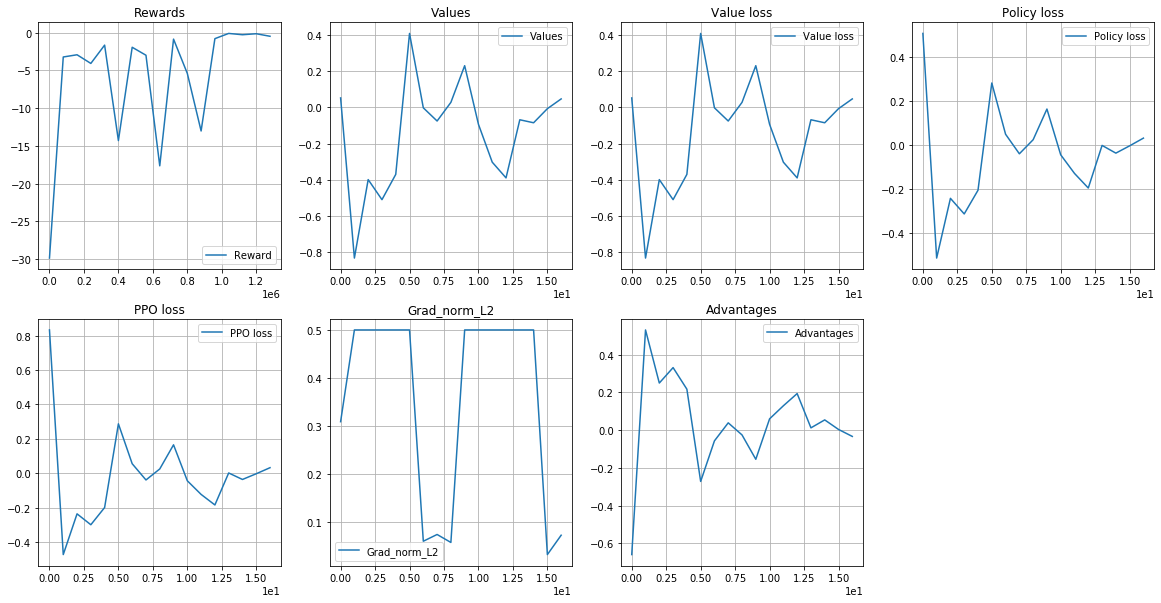

  1%|          | 8414/1000000 [17:24<31:10:29,  8.84it/s]  

KeyboardInterrupt: 

In [22]:
num_grad_per_trajectory = 5
ppo = PPO(policy, optimizer) 
num_steps = []
rewards = []
value_losses = []
policy_losses = []
values = []
grad_norms = []
advantages = []
ppo_losses = []
for i in trange(1_000_000):
    trajectory = runner.get_next()
    for j in range(num_grad_per_trajectory):
        ppo.step(trajectory)
    if i%500==0:
        clear_output(True)
        num_steps.append(runner.runner.step_var)
        value_losses.append(ppo.values_np)
        policy_losses.append(ppo.policy_loss_np)
        values.append(ppo.values_np)
        grad_norms.append(ppo.total_norm)
        advantages.append(ppo.advantages_np)
        ppo_losses.append(ppo.ppo_loss_np)
        
        rewards.append(np.mean(evaluate(env, model, n_games=3)))
        
        plt.figure(figsize=[20,10])
        
        plt.subplot(2,4,1)
        plt.plot(num_steps, rewards, label='Reward')
        plt.title("Rewards"); plt.grid(); plt.legend()
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

        plot_tools('Values', 2, values)
        plot_tools('Value loss', 3, value_losses)
        plot_tools('Policy loss', 4, policy_losses)
        plot_tools('PPO loss', 5, ppo_losses)
        plot_tools('Grad_norm_L2', 6, grad_norms) 
        plot_tools('Advantages', 7, advantages)

        plt.show()

In [ ]:
print('In the end', np.mean(evaluate(env, model, n_games=10)))